In [1]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from nn_utils import AE_3D_100, AE_3D_200
from utils import plot_activations
import utils

from scipy import stats

import corner.corner as corner
import seaborn as sns

# 1. Load Data

In [2]:

train = pd.read_pickle(BIN + 'processed_data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

train_mean = train.mean()
train_std = train.std()
    
# Normalize the data
def normalise(data):
    data_standard = (data - train_mean) / train_std #using training data mean and std for nomalisation
    return data_standard 

# Custom Standardise the data
eta_div = 5
phi_div = 3
m_div = 1.8
pt_div = 1.2
pt_sub = 1.3
m_add = 1

def standardise(data):
    data['eta'] = data['eta'] / eta_div
    data['phi'] = data['phi'] / phi_div
    data['m'] = np.log10(data['m'] + m_add) / m_div
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
    return data


In [3]:
train_normal_x = normalise(train)
test_normal_x = normalise(test)
train_normal_y = train_normal_x  # y = x since we are building an AutoEncoder
test_normal_y = test_normal_x

train_standard_x = standardise(train)
test_standard_x = standardise(test)
train_standard_y = train_standard_x  # y = x since we are building an AutoEncoder
test_standard_y = test_standard_x

In [4]:
#print(train_normal_x)
#print(train_standard_x)
print(train_normal_x.max())
print(train_normal_x.min())
print(train_standard_x.max())
print(train_standard_x.min())

               m        pt       phi       eta
132784 -0.688496 -0.607629  0.868107  0.759040
99666  -0.587358 -0.612672 -1.487534  0.117474
26629   1.051897  1.503479 -1.081401  0.773105
80473   0.788036  1.697702 -0.911068  1.813972
48229  -0.578692 -0.628716  1.619709 -0.830115
...          ...       ...       ...       ...
53491  -0.537380 -0.571190 -1.193353  1.110843
106817  0.634300  0.533333  1.351920  1.069930
61324  -0.453699 -0.576947  0.679283  1.020818
132003 -0.619830 -0.587073 -1.330767  0.765242
34752  -0.510834 -0.582428  1.675967 -0.932033

[111778 rows x 4 columns]
               m        pt       phi       eta
132784  1.990845  2.535362  0.522339  0.228585
99666   2.033994  2.529518 -0.893519  0.042731
26629   2.346657  3.274339 -0.649413  0.232659
80473   2.316659  3.302212 -0.547034  0.534185
48229   2.037356  2.510274  0.974090 -0.231774
...          ...       ...       ...       ...
53491   2.052769  2.574996 -0.716701  0.330498
106817  2.297290  3.089524  0.813

# 2. Histogram to visualise data

In [ ]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.8
n_bins = 100
model.to('cpu')

In [64]:
def histogram(data):
    plt.close('all')

    # Histograms
    idxs = (0, 100000)  # Choose events to compare
    data = data[idxs[0]:idxs[1]].values

    alph = 0.8
    n_bins = 50
    for kk in np.arange(4):
        plt.figure(kk + 4)
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        plt.suptitle(test.columns[kk])
        plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('Number of events')
        #plt.yscale('log')
        plt.legend()
        fig_name = 'trainforever_hist_%s' % train.columns[kk]
        #plt.savefig(curr_save_folder + fig_name)

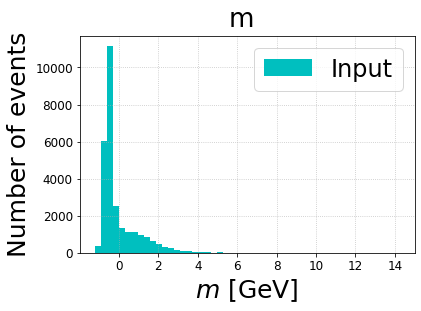

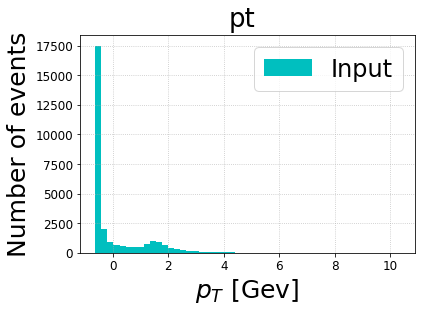

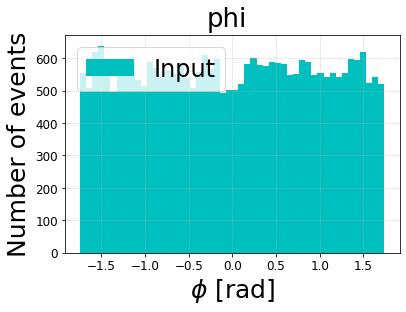

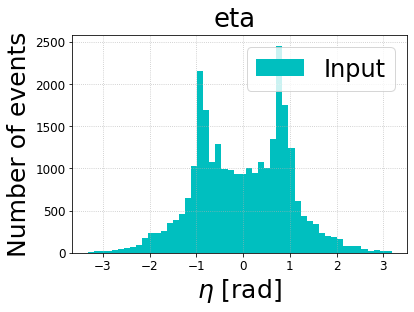

In [99]:
histogram(test_normal_x)

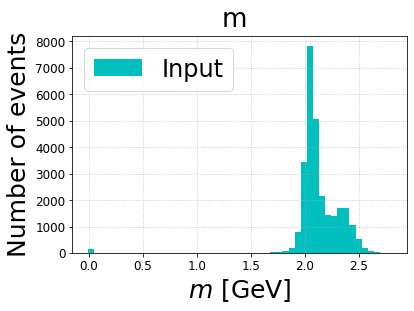

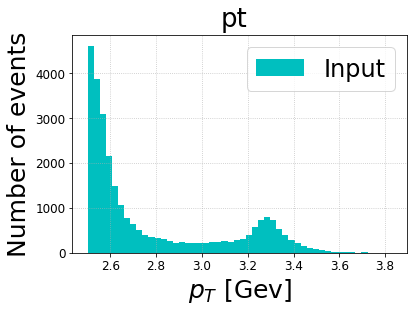

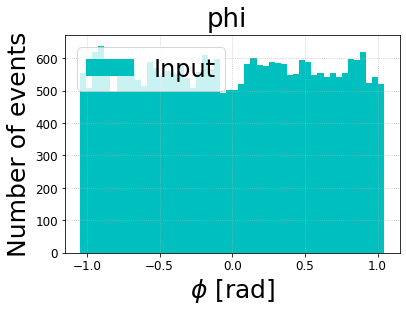

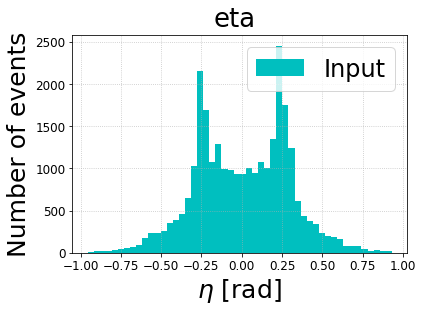

In [100]:
histogram(test_standard_x)

# 3. Load model and data as tensors

In [105]:
def get_data_bunch(train_x, train_y, test_x, test_y):
    
    def get_data(train_ds, valid_ds, bs):
        return (
            DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs * 2),
        )
    
    train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
    valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

    train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

    db = basic_data.DataBunch(train_dl, valid_dl)
    return db

model = AE_3D_200()

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6 #Weight decay

In [106]:
model

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [107]:
def learning(db, m):
    learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)
    learn.load(m)
    print(learn.validate())
    return learn

In [108]:
db_normal = get_data_bunch(train_normal_x, train_normal_y, test_normal_x, test_normal_y)
db_standard = get_data_bunch(train_standard_x, train_standard_y, test_standard_x, test_standard_y)

learn_normal = learning(db_normal, 'AE_3D_200_no1cycle_trainforever')
learn_standard = learning(db_standard, 'AE_3D_200_no1cycle_trainforever_standard')
#print(learn_normal)
#print(learn_standard)

[0.5058878]


[0.0009243198]


# 4. Reconstruct Data

In [109]:
#Reconstruct normalised data
def reconstruct_normal(data):
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    
    return data, pred

#Reconstruct custom standardised data
def reconstruct_standard(data):
    
    #Opposite of custom standardisation
    def unstandardise(data):
        data[:,0] = np.power(10, m_div * data[:,0] - m_add)
        data[:,1] = np.power(10, pt_div * data[:,1] + pt_sub)
        data[:,2] = data[:,2] * phi_div
        data[:,3] = data[:,3] * eta_div
        return data
        
    pred = model(data).detach().numpy()
    pred = unstandardise(pred)
    data = unstandardise(data)
    return data, pred

#Plot original and reconstructed data of 4 variables
def plot(data, pred):
    
    plt.close('all')
    
    for kk in np.arange(4):
        plt.figure(kk + 4)
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[0], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[1], label='Output', alpha=alph, bins=bin_edges)
        plt.suptitle(train_normal_x.columns[kk])
        plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('Number of events')
        ms.sciy()
        # plt.yscale('log')
        plt.legend()
        fig_name = 'trainforever_hist_%s' % train.columns[kk]
        #plt.savefig(curr_save_folder + fig_name)
        
def reconstruction_histogram(test_x, reconstruct_type):
    # Histograms
    idxs = (0, 100000)  # Choose events to compare
    data1 = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
    if(reconstruct_type == 'normal'):
        datas, pred = reconstruct_normal(data1)
    if(reconstruct_type == 'standard'):
        datas, pred = reconstruct_standard(data1)
    
    plot(datas,pred)
    return datas, pred

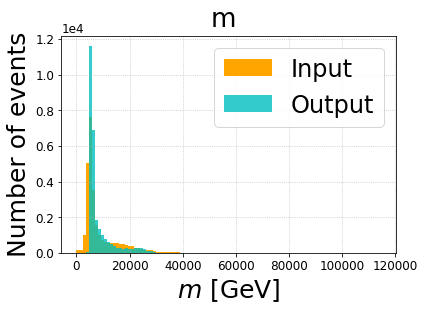

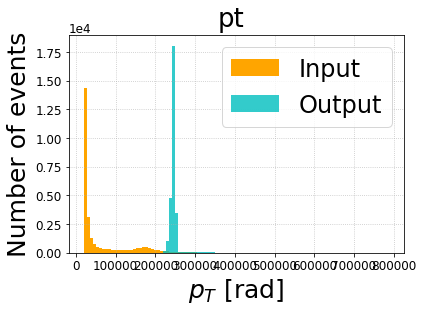

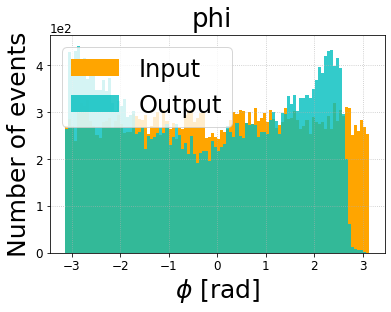

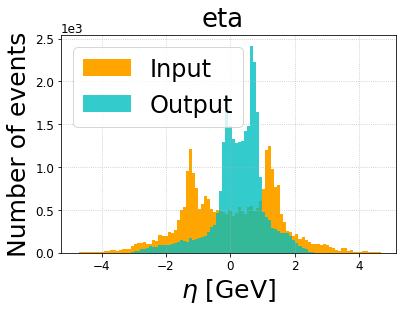

In [98]:
reconstructed_data_normal, reconstructed_pred_normal = reconstruction_histogram(test_normal_x, 'normal')

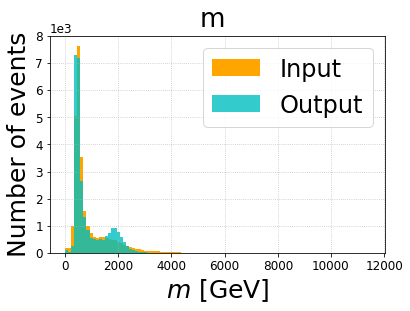

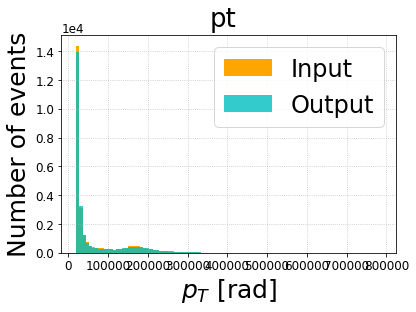

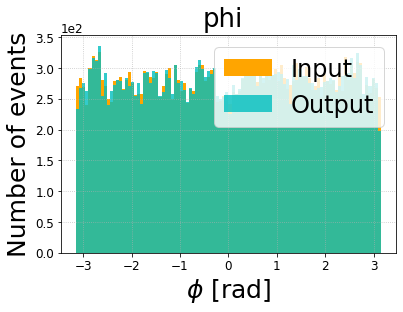

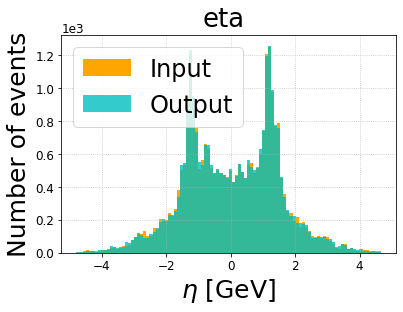

In [96]:
reconstructed_data_standard, reconstructed_pred_standard =reconstruction_histogram(test_standard_x, 'standard')

# 5. Reconstruction Loss

In [89]:
#Plot the reconstruction loss
def residual(data, pred):
    
    residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                            r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                            r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                            r'$(E_{out} - E_{in}) / E_{in}$']
    residuals = (pred - data.detach().numpy()) / data.detach().numpy() #Calculating the reconstruction loss
    print(residuals) 
    
    range = (-0.25, 0.25)  # Plot the residuals in this range (Since a good reconstruction should centre the losses
                           # around 0, plotting this range would allow visualisation in the range with more granularity)
    #range=None
    for kk in np.arange(4):
        plt.figure()
        n_hist_pred, bin_edges, _ = plt.hist(
            residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
        plt.suptitle('Residuals of %s' % train.columns[kk])
        plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
        plt.ylabel('Number of jets')
        ms.sciy()
        #plt.yscale('log')
        std = np.std(residuals[:, kk])
        std_err = utils.std_error(residuals[:, kk])
        mean = np.nanmean(residuals[:, kk])
        sem = stats.sem(residuals[:, kk], nan_policy='omit')
        ax = plt.gca()
        plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
                 horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
        fig_name = 'trainforever_residual_%s' % train.columns[kk]
        #plt.savefig(curr_save_folder + fig_name)
    return residuals

[[-0.048343  9.200796 -0.017032 -6.352861]
 [-0.053998 10.241369 -0.217819 -0.286754]
 [ 0.048913  8.923204  0.629303 -0.300714]
 [ 0.217953  0.126972  0.118154  0.042393]
 ...
 [-0.025057  8.165894  0.826103 -0.36211 ]
 [ 0.463058  8.852412  0.100832 -0.569661]
 [-0.203291  5.5645    0.113896 -1.012964]
 [-0.313041  3.624408  0.169296  0.160401]]


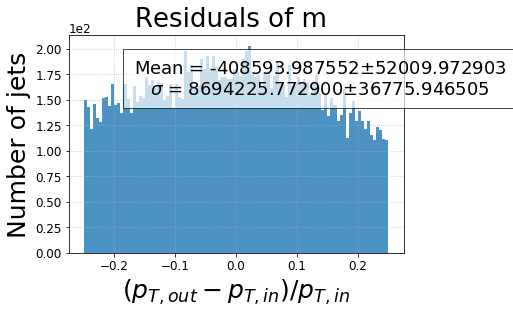

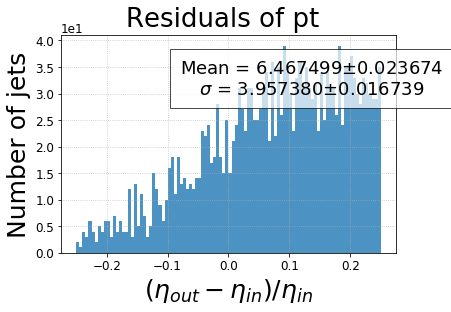

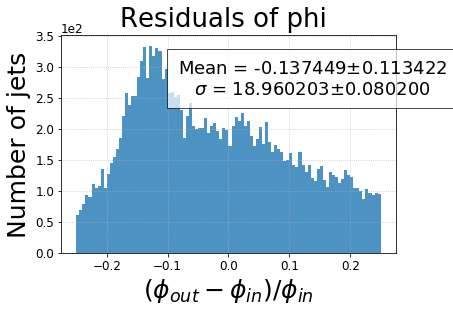

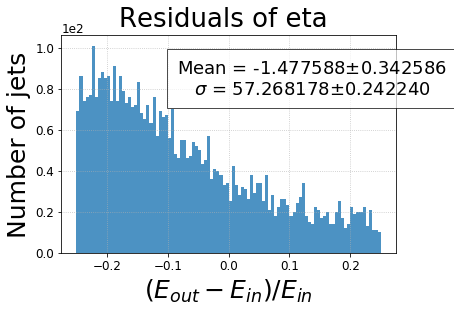

In [90]:
residuals_normal = residual(reconstructed_data_normal, reconstructed_pred_normal)

[[-2.615384e-02  6.696966e-05  7.116747e-04  1.751210e-02]
 [-1.525624e-01  5.244316e-02 -1.501002e-02 -2.758259e-02]
 [-4.622867e-02  6.787640e-04 -9.027450e-03 -7.783535e-03]
 [ 2.593150e-01 -1.161235e-01  2.403088e-03  3.371752e-03]
 ...
 [-6.084080e-02  2.168663e-03 -9.033883e-03 -1.392343e-02]
 [ 4.634412e-02 -3.868289e-03 -3.410083e-05  3.396433e-05]
 [-2.561160e-02 -4.840790e-04  6.543937e-03  2.933376e-02]
 [ 2.447727e-02  6.609540e-03  1.076638e-02  2.508845e-02]]


array([[-2.615384e-02,  6.696966e-05,  7.116747e-04,  1.751210e-02],
       [-1.525624e-01,  5.244316e-02, -1.501002e-02, -2.758259e-02],
       [-4.622867e-02,  6.787640e-04, -9.027450e-03, -7.783535e-03],
       [ 2.593150e-01, -1.161235e-01,  2.403088e-03,  3.371752e-03],
       ...,
       [-6.084080e-02,  2.168663e-03, -9.033883e-03, -1.392343e-02],
       [ 4.634412e-02, -3.868289e-03, -3.410083e-05,  3.396433e-05],
       [-2.561160e-02, -4.840790e-04,  6.543937e-03,  2.933376e-02],
       [ 2.447727e-02,  6.609540e-03,  1.076638e-02,  2.508845e-02]], dtype=float32)

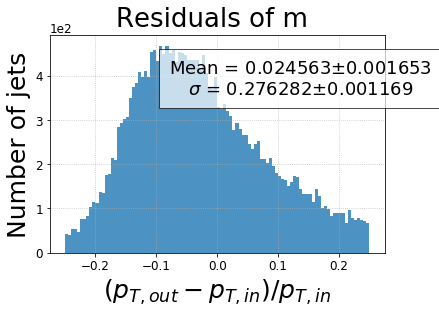

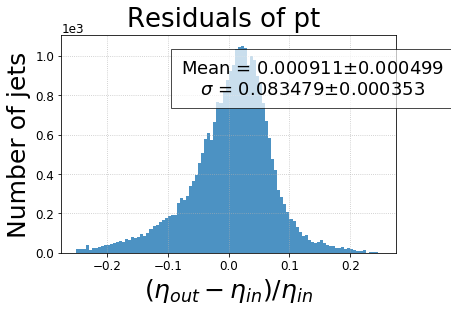

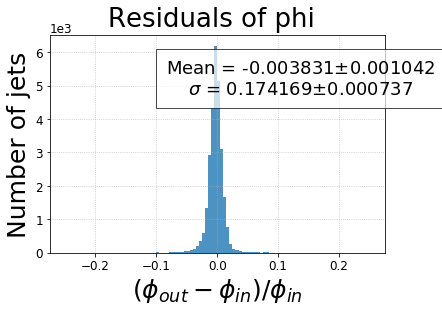

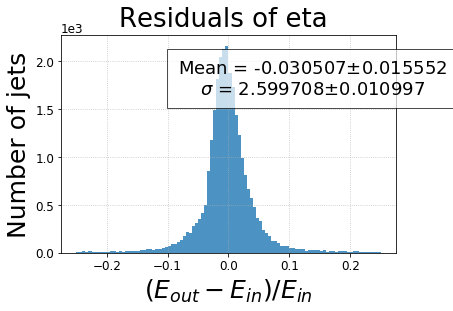

In [91]:
residuals_standard = residual(reconstructed_data_standard , reconstructed_pred_standard)
residuals_standard

In [94]:
sum(abs(residuals_standard))

array([4210.5957 , 1573.8503 ,  415.63806, 2487.95   ], dtype=float32)

# 6. Correlations between the variables' residuals

In [88]:
def correlations(residuals):
    res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
    save = False

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    #cmap = 'RdBu'
    norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    group = ['pt', 'eta', 'phi', 'E']

    label_kwargs = {'fontsize': 20}
    title_kwargs = {"fontsize": 11}
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    group_arr = res_df.values
    corr = res_df.corr()
    qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
    ndim = qs.shape[1]
    ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
    figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                    bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                    show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                    # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                    levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

    # # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    linecol = 'r'
    linstyl = 'dashed'
    # Loop over the histograms
    for yi in np.arange(ndim):
        for xi in np.arange(yi):
            ax = axes[yi, xi]
            # Set face color according to correlation
            ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
    cax = figure.add_axes([.87, .4, .04, 0.55])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation', fontsize=20)

    if save:
        fig_name = 'corner_3d.png'
        plt.savefig(curr_save_folder + fig_name)

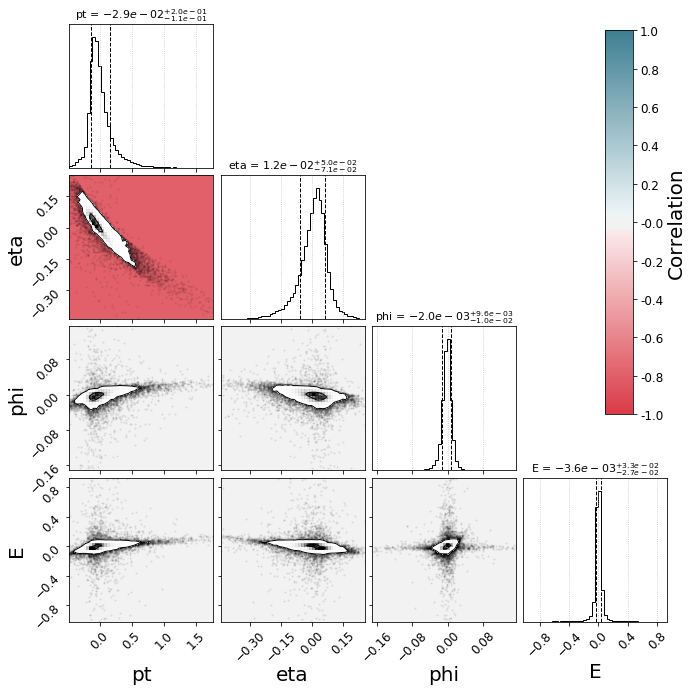

In [62]:
correlations(residuals_standard)


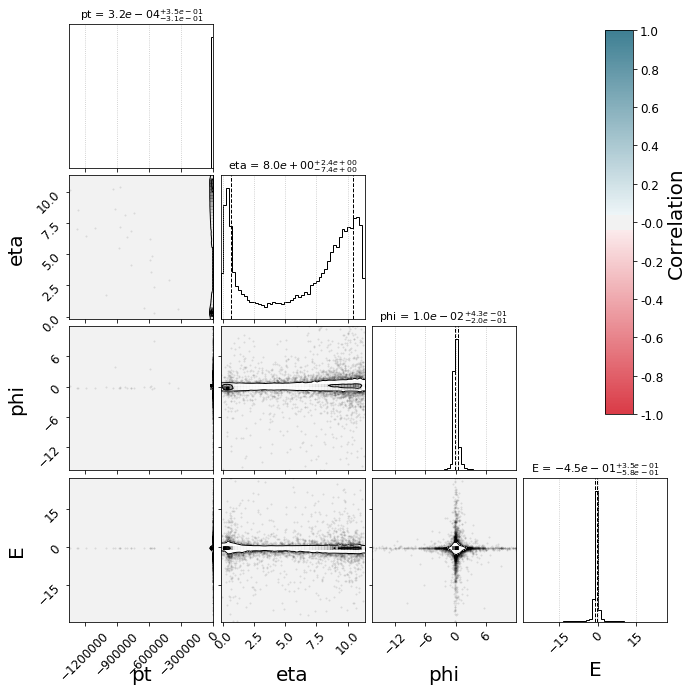

In [63]:
correlations(residuals_normal)